***BASED ON VR BASLINE***

***VR DATA***

Finds out where the trackers are placed based on the vr file data (Either shoulders, hip, or feet) ***Accurate***

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLVR.csv')

# Extract relevant columns
trackers = vr_data[['Tracker_01 [z]', 'Tracker_02 [z]', 'Tracker_03 [z]', 'Tracker_04 [z]', 'Tracker_05 [z]', 'Tracker_06 [z]', 'Tracker_07 [z]']]

# Use KMeans clustering to identify groups of trackers
kmeans = KMeans(n_clusters=3) # Shoulders, hips, or feet
tracker_labels = kmeans.fit_predict(trackers.T)

# Map the clusters to body parts (e.g., highest mean Z is shoulders, lowest is feet)
cluster_means = kmeans.cluster_centers_.mean(axis=1)
sorted_clusters = np.argsort(cluster_means)

# Assign labels based on sorted clusters
label_map = {sorted_clusters[0]: 'feet', sorted_clusters[1]: 'hips', sorted_clusters[2]: 'shoulders'}
tracker_positions = [label_map[label] for label in tracker_labels]

# Print or use the labeled tracker positions
for i, pos in enumerate(tracker_positions):
    print(f'Tracker_{i+1} is placed on: {pos}')


Tracker_1 is placed on: feet
Tracker_2 is placed on: hips
Tracker_3 is placed on: hips
Tracker_4 is placed on: hips
Tracker_5 is placed on: feet
Tracker_6 is placed on: shoulders
Tracker_7 is placed on: shoulders


Keeping track of only Z-coordinate (height displacement) of tracker 1, now with time synced to 0

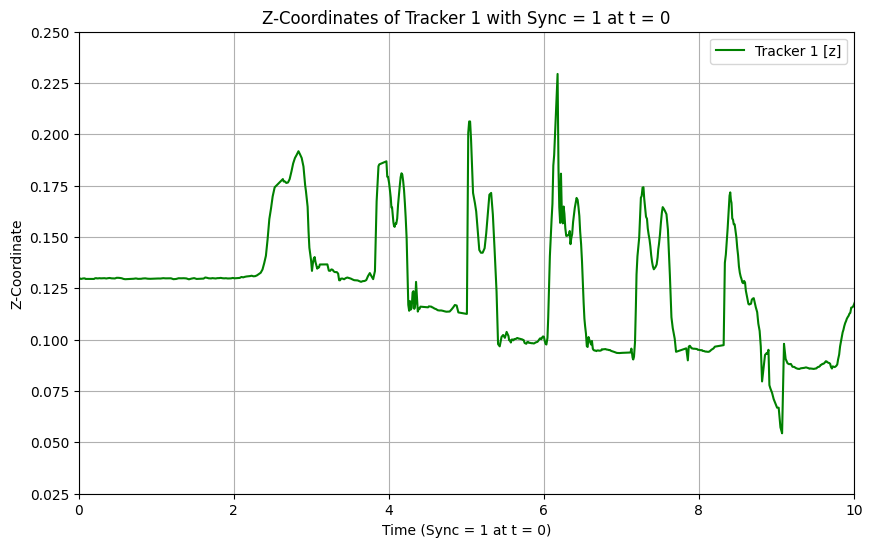

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLVR.csv')

# Filter data where Sync == 1
filtered_vr_data = vr_data[vr_data['Sync'] == 1].copy()  # Use .copy() to avoid chained indexing warning

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data['T'].min()

# Adjust time (T) relative to the first Sync = 1 occurrence
filtered_vr_data.loc[:, 'T_adjusted'] = filtered_vr_data['T'] - first_sync_time  # Use .loc to set values
#print(first_sync_time)

# Extract relevant columns
trackers = filtered_vr_data[['T_adjusted', 'Tracker_01 [z]']]  # Extracting Tracker 1

# Plot the data for Tracker 1
plt.figure(figsize=(10, 6))

plt.plot(trackers['T_adjusted'], trackers['Tracker_01 [z]'], label='Tracker 1 [z]', color='g')

plt.xlabel('Time (Sync = 1 at t = 0)')
plt.ylabel('Z-Coordinate')
plt.legend()
plt.title('Z-Coordinates of Tracker 1 with Sync = 1 at t = 0')
plt.grid(True)

# Zoom into the specified time interval
plt.xlim(0, 10)

# Zoom into the specified z interval
plt.ylim(0.025, 0.25)

plt.show()

# Find max and min values
max_value = trackers['Tracker_01 [z]'].max()
min_value = trackers['Tracker_01 [z]'].min()

# Find times corresponding to max and min values
time_at_max = trackers.loc[trackers['Tracker_01 [z]'].idxmax(), 'T_adjusted']
time_at_min = trackers.loc[trackers['Tracker_01 [z]'].idxmin(), 'T_adjusted']

In [34]:
print(filtered_vr_data.head())  # Display the first few rows of filtered data ***CORRECT***

      Unnamed: 0          T  Camera (eye) [ow]  Camera (eye) [ox]  \
1914        1914  27.879831           0.666999          -0.061650   
1915        1915  27.891350           0.666937          -0.062125   
1916        1916  27.901737           0.666847          -0.062686   
1917        1917  27.913364           0.666794          -0.063013   
1918        1918  27.924688           0.666963          -0.063344   

      Camera (eye) [oy]  Camera (eye) [oz]  Camera (eye) [x]  \
1914           0.006316           0.742477          1.804762   
1915           0.006053           0.742495          1.804391   
1916           0.005906           0.742530          1.804069   
1917           0.005661           0.742552          1.803742   
1918           0.005473           0.742373          1.803432   

      Camera (eye) [y]  Camera (eye) [z]  Tracker_01 [ow]  ...  vib_mode  \
1914          0.262494          1.673808         0.356677  ...         0   
1915          0.262682          1.673717        

In [2]:
print(vr_data.loc[1910:1920, ['Unnamed: 0', 'T', 'Sync']]) # Verifying above is correct

      Unnamed: 0          T  Sync
1910        1910  27.835939     0
1911        1911  27.846563     0
1912        1912  27.857317     0
1913        1913  27.867928     0
1914        1914  27.879831     1
1915        1915  27.891350     1
1916        1916  27.901737     1
1917        1917  27.913364     1
1918        1918  27.924688     1
1919        1919  27.934954     1
1920        1920  27.945461     1


***MAT DATA***

Accurate table comparing relevant info from MAT and VR info data (HS)

In [5]:
import pandas as pd

# Load the data
vr_data = pd.read_csv('BLVR.csv')
mat_data = pd.read_excel('HEA003 VR BASELINE.xlsx', skiprows=20)

# Filter MAT data to relevant columns and only right foot steps
filtered_mat_data = mat_data.iloc[:, :4].copy()
filtered_mat_data.columns = ['Sample #s', 'Left or Right', 'First Contact (HS)', 'Second Contact (TO)']
right_foot_data = filtered_mat_data[filtered_mat_data['Left or Right'].str.contains('Right')]

# Extract relevant columns for VR data
filtered_vr_data = vr_data[['T', 'Sync', 'Tracker_01 [z]']]

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data[filtered_vr_data['Sync'] == 1]['T'].min()

# Function to find the closest future time in VR data
def find_closest_future_time(vr_times, mat_time):
    future_times = vr_times[vr_times >= mat_time]
    return future_times.min() if len(future_times) > 0 else None

# Initialize lists to store results
results = []

# Process each right foot HS time
for index, row in right_foot_data.iterrows():
    mat_hs_time = row['First Contact (HS)']
    vr_time_offset = find_closest_future_time(filtered_vr_data['T'], mat_hs_time + first_sync_time)
    
    if vr_time_offset:
        vr_time_synced = vr_time_offset - first_sync_time
        accuracy = abs(vr_time_synced - mat_hs_time)
        accuracy_percentage = 100 - (accuracy / mat_hs_time * 100)
        
        # Fetch the corresponding Z-coordinate value
        z_coordinate = filtered_vr_data.loc[filtered_vr_data['T'] == vr_time_offset, 'Tracker_01 [z]'].values
        z_coordinate_value = z_coordinate[0] if len(z_coordinate) > 0 else None
        
        results.append((mat_hs_time, vr_time_offset, vr_time_synced, z_coordinate_value, accuracy, accuracy_percentage))

# Convert results to DataFrame for better display
results_df = pd.DataFrame(results, columns=['HS MAT Data Time (s)', 'VR Data Time (Offset, s)', 'VR Data Time (Synced, s)', 'Z-Coordinate', 'Accuracy (s)', 'Accuracy (%)'])
results_df


,HS MAT Data Time (s),"VR Data Time (Offset, s)","VR Data Time (Synced, s)",Z-Coordinate,Accuracy (s),Accuracy (%)
0,21.717,49.689278,21.809446,0.114333,0.092446,99.574314
1,22.925,50.805737,22.925905,0.100926,0.000905,99.996051
2,23.958,51.839249,23.959417,0.093587,0.001417,99.994084
3,24.917,52.804794,24.924963,0.095229,0.007963,99.968042
4,46.717,74.600235,46.720404,0.113913,0.003404,99.992714
5,47.808,75.768311,47.888479,0.126665,0.080479,99.831662
6,48.842,76.769539,48.889708,0.103759,0.047708,99.902323
7,49.817,77.699310,49.819479,0.165964,0.002479,99.995024
8,51.508,79.393005,51.513174,0.120411,0.005174,99.989955
9,62.858,90.749992,62.870161,0.192441,0.012161,99.980653


Plotted the HS times with their corresponding z-coordinates based on synced vr data

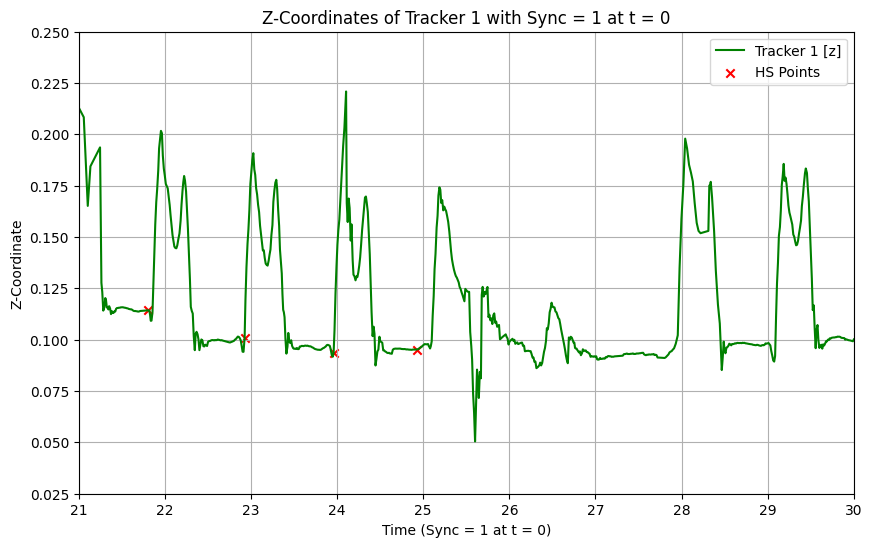

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLVR.csv')

# Filter data where Sync == 1
filtered_vr_data = vr_data[vr_data['Sync'] == 1].copy()  # Use .copy() to avoid chained indexing warning

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data['T'].min()

# Adjust time (T) relative to the first Sync = 1 occurrence
filtered_vr_data.loc[:, 'T_adjusted'] = filtered_vr_data['T'] - first_sync_time  # Use .loc to set values

# Extract relevant columns
trackers = filtered_vr_data[['T_adjusted', 'Tracker_01 [z]']]  # Extracting Tracker 1

# Plot the data for Tracker 1
plt.figure(figsize=(10, 6))

plt.plot(trackers['T_adjusted'], trackers['Tracker_01 [z]'], label='Tracker 1 [z]', color='g')

# Plot HS points from results_df
for index, row in results_df.iterrows():
    hs_time_synced = row['VR Data Time (Synced, s)']
    z_coordinate = filtered_vr_data.loc[filtered_vr_data['T_adjusted'] == hs_time_synced, 'Tracker_01 [z]'].values
    if len(z_coordinate) > 0:
        plt.scatter(hs_time_synced, z_coordinate, color='r', marker='x', label='HS Points' if index == 0 else "")

plt.xlabel('Time (Sync = 1 at t = 0)')
plt.ylabel('Z-Coordinate')
plt.legend()
plt.title('Z-Coordinates of Tracker 1 with Sync = 1 at t = 0')
plt.grid(True)

# Zoom into the specified time interval
plt.xlim(21, 30)

# Zoom into the specified z interval
plt.ylim(0.025, 0.25)

plt.show()

# Find max and min values
max_value = trackers['Tracker_01 [z]'].max()
min_value = trackers['Tracker_01 [z]'].min()

# Find times corresponding to max and min values
time_at_max = trackers.loc[trackers['Tracker_01 [z]'].idxmax(), 'T_adjusted']
time_at_min = trackers.loc[trackers['Tracker_01 [z]'].idxmin(), 'T_adjusted']

#print(f"Maximum Z-Coordinate value: {max_value} at time {time_at_max}")
#print(f"Minimum Z-Coordinate value: {min_value} at time {time_at_min}")


Accurate table comparing relevant info from MAT and VR info data (TO)

In [22]:
import pandas as pd

# Load the data
vr_data = pd.read_csv('BLVR.csv')
mat_data = pd.read_excel('HEA003 VR BASELINE.xlsx', skiprows=20)

# Filter MAT data to relevant columns and only right foot steps
filtered_mat_data = mat_data.iloc[:, :4].copy()
filtered_mat_data.columns = ['Sample #s', 'Left or Right', 'First Contact (HS)', 'Second Contact (TO)']
right_foot_data = filtered_mat_data[filtered_mat_data['Left or Right'].str.contains('Right')]

# Extract relevant columns for VR data
filtered_vr_data = vr_data[['T', 'Sync', 'Tracker_01 [z]']]

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data[filtered_vr_data['Sync'] == 1]['T'].min()

# Function to find the closest future time in VR data
def find_closest_future_time(vr_times, mat_time):
    future_times = vr_times[vr_times >= mat_time]
    return future_times.min() if len(future_times) > 0 else None

# Initialize lists to store results
results_to = []

# Process each right foot TO time
for index, row in right_foot_data.iterrows():
    mat_to_time = row['Second Contact (TO)']
    vr_time_offset = find_closest_future_time(filtered_vr_data['T'], mat_to_time + first_sync_time)
    
    if vr_time_offset:
        vr_time_synced = vr_time_offset - first_sync_time
        accuracy = abs(vr_time_synced - mat_to_time)
        accuracy_percentage = 100 - (accuracy / mat_to_time * 100)
        
        # Fetch the corresponding Z-coordinate value
        z_coordinate = filtered_vr_data.loc[filtered_vr_data['T'] == vr_time_offset, 'Tracker_01 [z]'].values
        z_coordinate_value = z_coordinate[0] if len(z_coordinate) > 0 else None
        
        results_to.append((mat_to_time, vr_time_offset, vr_time_synced, z_coordinate_value, accuracy, accuracy_percentage))

# Convert results to DataFrame for better display
results_to_df = pd.DataFrame(results_to, columns=['TO MAT Data Time (s)', 'VR Data Time (Offset, s)', 'VR Data Time (Synced, s)', 'Z-Coordinate', 'Accuracy (s)', 'Accuracy (%)'])
results_to_df


,TO MAT Data Time (s),"VR Data Time (Offset, s)","VR Data Time (Synced, s)",Z-Coordinate,Accuracy (s),Accuracy (%)
0,22.550,50.439140,22.559309,0.099824,0.009309,99.958718
1,23.633,51.512886,23.633055,0.097139,0.000055,99.999768
2,24.608,52.493484,24.613653,0.093282,0.005653,99.977027
3,25.625,53.516277,25.636446,0.079834,0.011446,99.955333
4,47.467,75.360153,47.480322,0.210697,0.013322,99.971934
5,48.508,76.388519,48.508688,0.165849,0.000688,99.998582
6,49.500,77.390617,49.510786,0.130075,0.010786,99.978210
7,50.483,78.370499,50.490667,0.123362,0.007667,99.984812
8,51.983,79.906822,52.026991,0.176259,0.043991,99.915374
9,63.750,91.631317,63.751486,0.164279,0.001486,99.997669


Plotted the TO times with their corresponding z-coordinates based on synced vr data

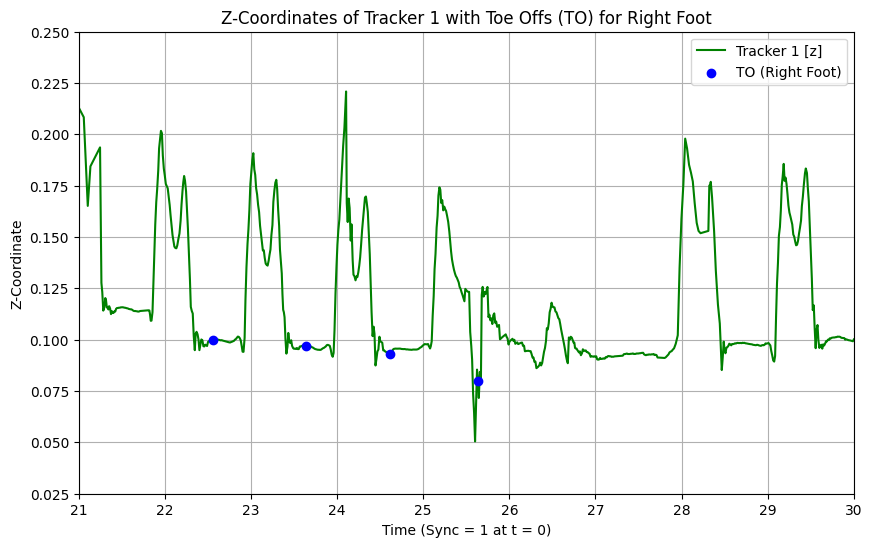

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLVR.csv')
mat_data = pd.read_excel('HEA003 VR BASELINE.xlsx', skiprows=20)

# Filter MAT data to relevant columns and only right foot steps
filtered_mat_data = mat_data.iloc[:, :4].copy()
filtered_mat_data.columns = ['Sample #s', 'Left or Right', 'First Contact (HS)', 'Second Contact (TO)']
right_foot_data = filtered_mat_data[filtered_mat_data['Left or Right'].str.contains('Right')]

# Extract relevant columns for VR data
filtered_vr_data = vr_data[['T', 'Sync', 'Tracker_01 [z]']]

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data[filtered_vr_data['Sync'] == 1]['T'].min()

# Function to find the closest future time in VR data
def find_closest_future_time(vr_times, mat_time):
    future_times = vr_times[vr_times >= mat_time]
    return future_times.min() if len(future_times) > 0 else None

# Initialize lists to store results
results_to = []

# Process each right foot TO time
for index, row in right_foot_data.iterrows():
    mat_to_time = row['Second Contact (TO)']
    vr_time_offset = find_closest_future_time(filtered_vr_data['T'], mat_to_time + first_sync_time)
    
    if vr_time_offset:
        vr_time_synced = vr_time_offset - first_sync_time
        accuracy = abs(vr_time_synced - mat_to_time)
        accuracy_percentage = 100 - (accuracy / mat_to_time * 100)
        
        # Fetch the corresponding Z-coordinate value
        z_coordinate = filtered_vr_data.loc[filtered_vr_data['T'] == vr_time_offset, 'Tracker_01 [z]'].values
        z_coordinate_value = z_coordinate[0] if len(z_coordinate) > 0 else None
        
        results_to.append((mat_to_time, vr_time_offset, vr_time_synced, z_coordinate_value, accuracy, accuracy_percentage))

# Convert results to DataFrame for better display
results_to_df = pd.DataFrame(results_to, columns=['TO MAT Data Time (s)', 'VR Data Time (Offset, s)', 'VR Data Time (Synced, s)', 'Z-Coordinate', 'Accuracy (s)', 'Accuracy (%)'])

# Plotting the Z-coordinates of Tracker 1 with TO points
# Filter data where Sync == 1
filtered_vr_data_sync = vr_data[vr_data['Sync'] == 1].copy()  # Use .copy() to avoid chained indexing warning

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data_sync['T'].min()

# Adjust time (T) relative to the first Sync = 1 occurrence
filtered_vr_data_sync.loc[:, 'T_adjusted'] = filtered_vr_data_sync['T'] - first_sync_time  # Use .loc to set values

# Extract relevant columns
trackers = filtered_vr_data_sync[['T_adjusted', 'Tracker_01 [z]']]  # Extracting Tracker 1

# Plot the data for Tracker 4
plt.figure(figsize=(10, 6))
plt.plot(trackers['T_adjusted'], trackers['Tracker_01 [z]'], label='Tracker 1 [z]', color='g')

# Plot TO points
plt.scatter(results_to_df['VR Data Time (Synced, s)'], results_to_df['Z-Coordinate'], color='blue', label='TO (Right Foot)', zorder=5)

plt.xlabel('Time (Sync = 1 at t = 0)')
plt.ylabel('Z-Coordinate')
plt.legend()
plt.title('Z-Coordinates of Tracker 1 with Toe Offs (TO) for Right Foot')
plt.grid(True)

# Zoom into the specified time interval
plt.xlim(21, 30)

# Zoom into the specified z interval
plt.ylim(0.025, 0.25)

plt.show()


***BASED ON NECKBRACE BASLINE***

***VR DATA***

Finds out where the trackers are placed based on the vr file data (Either shoulders, hip, or feet) ***Accurate***

In [31]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLNB.csv')

# Extract relevant columns
trackers = vr_data[['Tracker_01 [z]', 'Tracker_02 [z]', 'Tracker_03 [z]', 'Tracker_04 [z]', 'Tracker_05 [z]', 'Tracker_06 [z]', 'Tracker_07 [z]']]

# Use KMeans clustering to identify groups of trackers
kmeans = KMeans(n_clusters=3) # Shoulders, hips, or feet
tracker_labels = kmeans.fit_predict(trackers.T)

# Map the clusters to body parts (e.g., highest mean Z is shoulders, lowest is feet)
cluster_means = kmeans.cluster_centers_.mean(axis=1)
sorted_clusters = np.argsort(cluster_means)

# Assign labels based on sorted clusters
label_map = {sorted_clusters[0]: 'feet', sorted_clusters[1]: 'hips', sorted_clusters[2]: 'shoulders'}
tracker_positions = [label_map[label] for label in tracker_labels]

# Print or use the labeled tracker positions
for i, pos in enumerate(tracker_positions):
    print(f'Tracker_{i+1} is placed on: {pos}')


Tracker_1 is placed on: feet
Tracker_2 is placed on: hips
Tracker_3 is placed on: hips
Tracker_4 is placed on: hips
Tracker_5 is placed on: shoulders
Tracker_6 is placed on: feet
Tracker_7 is placed on: shoulders


Keeping track of only Z-coordinate (height displacement) of tracker 1, now with time synced to 0

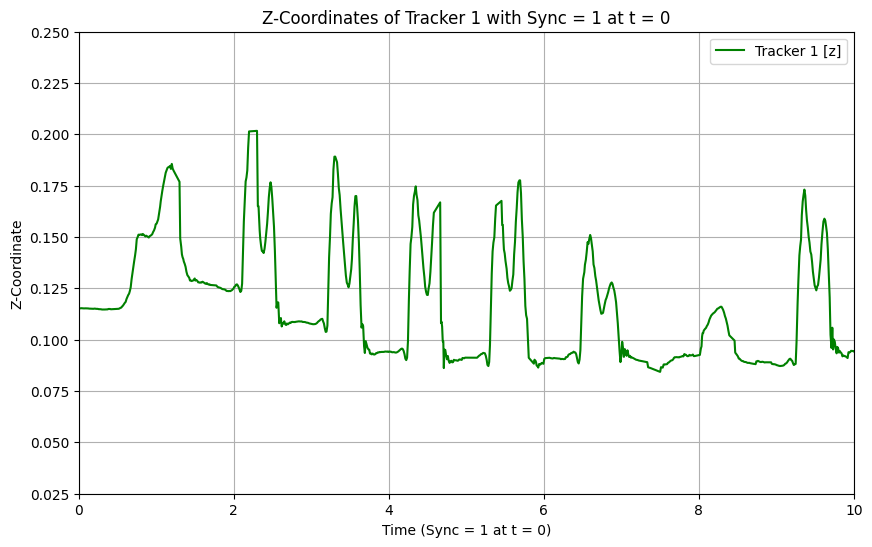

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLNB.csv')

# Filter data where Sync == 1
filtered_vr_data = vr_data[vr_data['Sync'] == 1].copy()  # Use .copy() to avoid chained indexing warning

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data['T'].min()

# Adjust time (T) relative to the first Sync = 1 occurrence
filtered_vr_data.loc[:, 'T_adjusted'] = filtered_vr_data['T'] - first_sync_time  # Use .loc to set values
#print(first_sync_time)

# Extract relevant columns
trackers = filtered_vr_data[['T_adjusted', 'Tracker_01 [z]']]  # Extracting Tracker 1

# Plot the data for Tracker 1
plt.figure(figsize=(10, 6))

plt.plot(trackers['T_adjusted'], trackers['Tracker_01 [z]'], label='Tracker 1 [z]', color='g')

plt.xlabel('Time (Sync = 1 at t = 0)')
plt.ylabel('Z-Coordinate')
plt.legend()
plt.title('Z-Coordinates of Tracker 1 with Sync = 1 at t = 0')
plt.grid(True)

# Zoom into the specified time interval
plt.xlim(0, 10)

# Zoom into the specified z interval
plt.ylim(0.025, 0.25)

plt.show()

# Find max and min values
max_value = trackers['Tracker_01 [z]'].max()
min_value = trackers['Tracker_01 [z]'].min()

# Find times corresponding to max and min values
time_at_max = trackers.loc[trackers['Tracker_01 [z]'].idxmax(), 'T_adjusted']
time_at_min = trackers.loc[trackers['Tracker_01 [z]'].idxmin(), 'T_adjusted']

In [33]:
print(filtered_vr_data.head())  # Display the first few rows of filtered data ***CORRECT***

     Unnamed: 0          T  Camera (eye) [ow]  Camera (eye) [ox]  \
861         861  12.312155          -0.299241          -0.042409   
862         862  12.323007          -0.299332          -0.042443   
863         863  12.334172          -0.299222          -0.042344   
864         864  12.345290          -0.299355          -0.042300   
865         865  12.356318          -0.299358          -0.042426   

     Camera (eye) [oy]  Camera (eye) [oz]  Camera (eye) [x]  Camera (eye) [y]  \
861          -0.014264          -0.953128         -0.906352          1.234024   
862          -0.014247          -0.953098         -0.906357          1.234007   
863          -0.014381          -0.953135         -0.906426          1.233918   
864          -0.014251          -0.953097         -0.906459          1.233916   
865          -0.014288          -0.953090         -0.906423          1.233944   

     Camera (eye) [z]  Tracker_01 [ow]  ...  vib_mode  \
861          0.557597         0.352858  ...    

In [34]:
print(vr_data.loc[1910:1920, ['Unnamed: 0', 'T', 'Sync']]) # Verifying above is correct

      Unnamed: 0          T  Sync
1910        1910  24.715212     1
1911        1911  24.726837     1
1912        1912  24.737646     1
1913        1913  24.749083     1
1914        1914  24.760845     1
1915        1915  24.770844     1
1916        1916  24.782413     1
1917        1917  24.793129     1
1918        1918  24.803928     1
1919        1919  24.815523     1
1920        1920  24.826403     1


***MAT DATA***

Accurate table comparing relevant info from MAT and VR info data (HS)

In [35]:
import pandas as pd

# Load the data
vr_data = pd.read_csv('BLNB.csv')
mat_data = pd.read_excel('HEA003 NECKBRACE BASELINE.xlsx', skiprows=20)

# Filter MAT data to relevant columns and only right foot steps
filtered_mat_data = mat_data.iloc[:, :4].copy()
filtered_mat_data.columns = ['Sample #s', 'Left or Right', 'First Contact (HS)', 'Second Contact (TO)']
right_foot_data = filtered_mat_data[filtered_mat_data['Left or Right'].str.contains('Right')]

# Extract relevant columns for VR data
filtered_vr_data = vr_data[['T', 'Sync', 'Tracker_01 [z]']]

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data[filtered_vr_data['Sync'] == 1]['T'].min()

# Function to find the closest future time in VR data
def find_closest_future_time(vr_times, mat_time):
    future_times = vr_times[vr_times >= mat_time]
    return future_times.min() if len(future_times) > 0 else None

# Initialize lists to store results
results = []

# Process each right foot HS time
for index, row in right_foot_data.iterrows():
    mat_hs_time = row['First Contact (HS)']
    vr_time_offset = find_closest_future_time(filtered_vr_data['T'], mat_hs_time + first_sync_time)
    
    if vr_time_offset:
        vr_time_synced = vr_time_offset - first_sync_time
        accuracy = abs(vr_time_synced - mat_hs_time)
        accuracy_percentage = 100 - (accuracy / mat_hs_time * 100)
        
        # Fetch the corresponding Z-coordinate value
        z_coordinate = filtered_vr_data.loc[filtered_vr_data['T'] == vr_time_offset, 'Tracker_01 [z]'].values
        z_coordinate_value = z_coordinate[0] if len(z_coordinate) > 0 else None
        
        results.append((mat_hs_time, vr_time_offset, vr_time_synced, z_coordinate_value, accuracy, accuracy_percentage))

# Convert results to DataFrame for better display
results_df = pd.DataFrame(results, columns=['HS MAT Data Time (s)', 'VR Data Time (Offset, s)', 'VR Data Time (Synced, s)', 'Z-Coordinate', 'Accuracy (s)', 'Accuracy (%)'])
results_df


,HS MAT Data Time (s),"VR Data Time (Offset, s)","VR Data Time (Synced, s)",Z-Coordinate,Accuracy (s),Accuracy (%)
0,2.025,14.342094,2.029940,0.126840,0.004940,99.756067
1,3.142,15.454691,3.142536,0.110172,0.000536,99.982936
2,4.167,16.482546,4.170391,0.095693,0.003391,99.918621
3,5.242,17.563868,5.251713,0.092196,0.009713,99.814712
4,9.142,21.461233,9.149078,0.089550,0.007078,99.922573
...,...,...,...,...,...,...
75,122.650,134.970337,122.658182,0.093266,0.008182,99.993329
76,126.183,138.498886,126.186731,0.098784,0.003731,99.997043
77,127.242,139.564972,127.252817,0.092292,0.010817,99.991499
78,128.292,140.604721,128.292566,0.098894,0.000566,99.999559


Plotted the HS times with their corresponding z-coordinates based on synced vr data

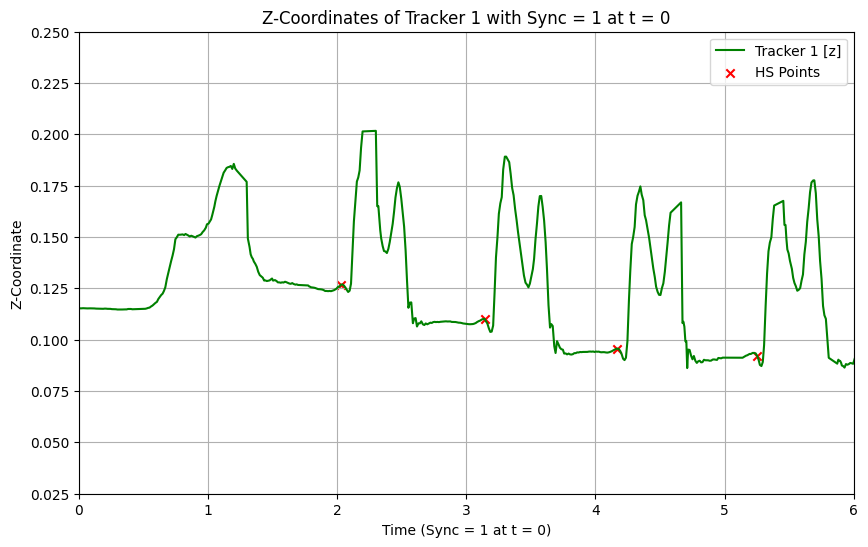

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLNB.csv')

# Filter data where Sync == 1
filtered_vr_data = vr_data[vr_data['Sync'] == 1].copy()  # Use .copy() to avoid chained indexing warning

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data['T'].min()

# Adjust time (T) relative to the first Sync = 1 occurrence
filtered_vr_data.loc[:, 'T_adjusted'] = filtered_vr_data['T'] - first_sync_time  # Use .loc to set values

# Extract relevant columns
trackers = filtered_vr_data[['T_adjusted', 'Tracker_01 [z]']]  # Extracting Tracker 1

# Plot the data for Tracker 1
plt.figure(figsize=(10, 6))

plt.plot(trackers['T_adjusted'], trackers['Tracker_01 [z]'], label='Tracker 1 [z]', color='g')

# Plot HS points from results_df
for index, row in results_df.iterrows():
    hs_time_synced = row['VR Data Time (Synced, s)']
    z_coordinate = filtered_vr_data.loc[filtered_vr_data['T_adjusted'] == hs_time_synced, 'Tracker_01 [z]'].values
    if len(z_coordinate) > 0:
        plt.scatter(hs_time_synced, z_coordinate, color='r', marker='x', label='HS Points' if index == 0 else "")

plt.xlabel('Time (Sync = 1 at t = 0)')
plt.ylabel('Z-Coordinate')
plt.legend()
plt.title('Z-Coordinates of Tracker 1 with Sync = 1 at t = 0')
plt.grid(True)

# Zoom into the specified time interval
plt.xlim(0, 6)

# Zoom into the specified z interval
plt.ylim(0.025, 0.25)

plt.show()

# Find max and min values
max_value = trackers['Tracker_01 [z]'].max()
min_value = trackers['Tracker_01 [z]'].min()

# Find times corresponding to max and min values
time_at_max = trackers.loc[trackers['Tracker_01 [z]'].idxmax(), 'T_adjusted']
time_at_min = trackers.loc[trackers['Tracker_01 [z]'].idxmin(), 'T_adjusted']

#print(f"Maximum Z-Coordinate value: {max_value} at time {time_at_max}")
#print(f"Minimum Z-Coordinate value: {min_value} at time {time_at_min}")


Accurate table comparing relevant info from MAT and VR info data (TO)

In [40]:
import pandas as pd

# Load the data
vr_data = pd.read_csv('BLNB.csv')
mat_data = pd.read_excel('HEA003 NECKBRACE BASELINE.xlsx', skiprows=20)

# Filter MAT data to relevant columns and only right foot steps
filtered_mat_data = mat_data.iloc[:, :4].copy()
filtered_mat_data.columns = ['Sample #s', 'Left or Right', 'First Contact (HS)', 'Second Contact (TO)']
right_foot_data = filtered_mat_data[filtered_mat_data['Left or Right'].str.contains('Right')]

# Extract relevant columns for VR data
filtered_vr_data = vr_data[['T', 'Sync', 'Tracker_01 [z]']]

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data[filtered_vr_data['Sync'] == 1]['T'].min()

# Function to find the closest future time in VR data
def find_closest_future_time(vr_times, mat_time):
    future_times = vr_times[vr_times >= mat_time]
    return future_times.min() if len(future_times) > 0 else None

# Initialize lists to store results
results_to = []

# Process each right foot TO time
for index, row in right_foot_data.iterrows():
    mat_to_time = row['Second Contact (TO)']
    vr_time_offset = find_closest_future_time(filtered_vr_data['T'], mat_to_time + first_sync_time)
    
    if vr_time_offset:
        vr_time_synced = vr_time_offset - first_sync_time
        accuracy = abs(vr_time_synced - mat_to_time)
        accuracy_percentage = 100 - (accuracy / mat_to_time * 100)
        
        # Fetch the corresponding Z-coordinate value
        z_coordinate = filtered_vr_data.loc[filtered_vr_data['T'] == vr_time_offset, 'Tracker_01 [z]'].values
        z_coordinate_value = z_coordinate[0] if len(z_coordinate) > 0 else None
        
        results_to.append((mat_to_time, vr_time_offset, vr_time_synced, z_coordinate_value, accuracy, accuracy_percentage))

# Convert results to DataFrame for better display
results_to_df = pd.DataFrame(results_to, columns=['TO MAT Data Time (s)', 'VR Data Time (Offset, s)', 'VR Data Time (Synced, s)', 'Z-Coordinate', 'Accuracy (s)', 'Accuracy (%)'])
results_to_df


,TO MAT Data Time (s),"VR Data Time (Offset, s)","VR Data Time (Synced, s)",Z-Coordinate,Accuracy (s),Accuracy (%)
0,2.758,15.076974,2.764819,0.108582,0.006819,99.752750
1,3.833,16.148354,3.836199,0.093465,0.003199,99.916546
2,4.858,17.175097,4.862942,0.089988,0.004942,99.898276
3,5.975,18.296108,5.983953,0.088520,0.008953,99.850151
4,9.900,22.221811,9.909657,0.091413,0.009657,99.902459
...,...,...,...,...,...,...
75,123.433,135.755539,123.443384,0.085826,0.010384,99.991587
76,126.858,139.176819,126.864664,0.095960,0.006664,99.994747
77,127.900,140.216293,127.904139,0.097654,0.004139,99.996764
78,128.983,141.360550,129.048395,0.109135,0.065395,99.949299


Plotted the TO times with their corresponding z-coordinates based on synced vr data

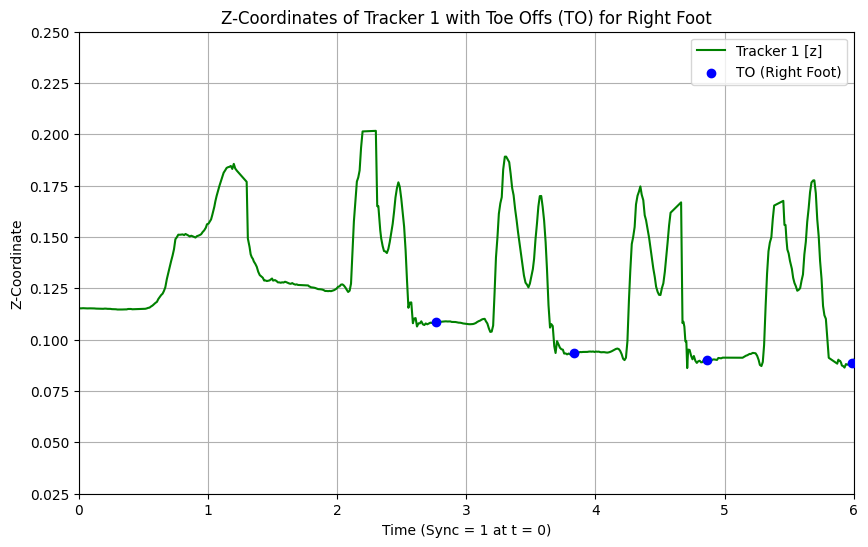

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
vr_data = pd.read_csv('BLNB.csv')
mat_data = pd.read_excel('HEA003 NECKBRACE BASELINE.xlsx', skiprows=20)

# Filter MAT data to relevant columns and only right foot steps
filtered_mat_data = mat_data.iloc[:, :4].copy()
filtered_mat_data.columns = ['Sample #s', 'Left or Right', 'First Contact (HS)', 'Second Contact (TO)']
right_foot_data = filtered_mat_data[filtered_mat_data['Left or Right'].str.contains('Right')]

# Extract relevant columns for VR data
filtered_vr_data = vr_data[['T', 'Sync', 'Tracker_01 [z]']]

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data[filtered_vr_data['Sync'] == 1]['T'].min()

# Function to find the closest future time in VR data
def find_closest_future_time(vr_times, mat_time):
    future_times = vr_times[vr_times >= mat_time]
    return future_times.min() if len(future_times) > 0 else None

# Initialize lists to store results
results_to = []

# Process each right foot TO time
for index, row in right_foot_data.iterrows():
    mat_to_time = row['Second Contact (TO)']
    vr_time_offset = find_closest_future_time(filtered_vr_data['T'], mat_to_time + first_sync_time)
    
    if vr_time_offset:
        vr_time_synced = vr_time_offset - first_sync_time
        accuracy = abs(vr_time_synced - mat_to_time)
        accuracy_percentage = 100 - (accuracy / mat_to_time * 100)
        
        # Fetch the corresponding Z-coordinate value
        z_coordinate = filtered_vr_data.loc[filtered_vr_data['T'] == vr_time_offset, 'Tracker_01 [z]'].values
        z_coordinate_value = z_coordinate[0] if len(z_coordinate) > 0 else None
        
        results_to.append((mat_to_time, vr_time_offset, vr_time_synced, z_coordinate_value, accuracy, accuracy_percentage))

# Convert results to DataFrame for better display
results_to_df = pd.DataFrame(results_to, columns=['TO MAT Data Time (s)', 'VR Data Time (Offset, s)', 'VR Data Time (Synced, s)', 'Z-Coordinate', 'Accuracy (s)', 'Accuracy (%)'])

# Plotting the Z-coordinates of Tracker 1 with TO points
# Filter data where Sync == 1
filtered_vr_data_sync = vr_data[vr_data['Sync'] == 1].copy()  # Use .copy() to avoid chained indexing warning

# Find the first occurrence of Sync = 1
first_sync_time = filtered_vr_data_sync['T'].min()

# Adjust time (T) relative to the first Sync = 1 occurrence
filtered_vr_data_sync.loc[:, 'T_adjusted'] = filtered_vr_data_sync['T'] - first_sync_time  # Use .loc to set values

# Extract relevant columns
trackers = filtered_vr_data_sync[['T_adjusted', 'Tracker_01 [z]']]  # Extracting Tracker 1

# Plot the data for Tracker 4
plt.figure(figsize=(10, 6))
plt.plot(trackers['T_adjusted'], trackers['Tracker_01 [z]'], label='Tracker 1 [z]', color='g')

# Plot TO points
plt.scatter(results_to_df['VR Data Time (Synced, s)'], results_to_df['Z-Coordinate'], color='blue', label='TO (Right Foot)', zorder=5)

plt.xlabel('Time (Sync = 1 at t = 0)')
plt.ylabel('Z-Coordinate')
plt.legend()
plt.title('Z-Coordinates of Tracker 1 with Toe Offs (TO) for Right Foot')
plt.grid(True)

# Zoom into the specified time interval
plt.xlim(0, 6)

# Zoom into the specified z interval
plt.ylim(0.025, 0.25)

plt.show()
